In [1]:
import os
import json
import pandas as pd
import numpy as np
import curvlearn as cv
from curvlearn.manifolds.manifold import Manifold
import torch
import torch.nn as nn
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from diffpool_helpers.model.diffpool_continuous import TSDiffPool
import argparse
import time
import random
from functools import lru_cache
import networkx as nx
import yfinance
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import timedelta
import datetime
import requests
import dgl

Instructions for updating:
non-resource variables are not supported in the long term


/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Getting Data

## Import X

In [2]:
dt = {}
all_cols = None
for file in os.listdir('imputed_data'):
    if file.endswith('.csv'):
        k = file.split('_')[0]
        dt[k] = pd.read_csv(os.path.join('imputed_data', file))

In [3]:
dt = {k: v for k, v in dt.items() if len(v) >= 7 and len(v.columns) >= 5}

In [4]:
for k in dt:
    try:
        dt[k].index = dt[k]["index"]
    except:
        print(k, dt[k].columns)

In [5]:
np.unique([len(df.columns) for df in dt.values()])

array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49])

In [6]:
def parse_columns(df):
    """
    Function to parse column names and remove the {ticker}: prefix.
    """
    new_columns = []
    for col in df.columns:
        if ":" in col:
            ticker, real_col_name = col.split(":")
            new_columns.append(real_col_name)
        else:
            new_columns.append(col)
    return new_columns

# Get the union of all column names across the DataFrames
all_cols = set().union(*[set(parse_columns(df)) for df in dt.values()])
list(all_cols)

# Update the column names for each DataFrame
for k in list(dt.keys()):
    dt[k].columns = parse_columns(dt[k])
    try:
        dt[k] = dt[k].reindex(columns=all_cols, fill_value=0)
    except Exception as e:
        print(k, e)

In [7]:
def decrement_quarter(quarter_str):
    year = int(quarter_str[:4])
    quarter = int(quarter_str[-1])

    if quarter == 1:
        year -= 1
        quarter = 4
    else:
        quarter -= 1

    return f"{year}Q{quarter}"


In [8]:
np.unique([len(df.columns) for df in dt.values()])

array([57])

## Import Y

In [9]:
bulk_prices = {}
all_cols = None
for file in os.listdir('bulk_prices_data'):
    if file.endswith('.csv'):
        k = file.split('_')[0]
        bulk_prices[k] = pd.read_csv(os.path.join('bulk_prices_data', file))

# Clean Y

In [10]:
def q_to_date(year, quarter):
    if quarter == 1:
        return datetime.datetime(year, 3, 31, 14, 59)
    elif quarter == 2:
        return datetime.datetime(year, 6, 30, 14, 59)
    elif quarter == 3:
        return datetime.datetime(year, 9, 30, 14, 59)
    elif quarter == 4:
        return datetime.datetime(year, 12, 31, 14, 59)
    else:
        raise ValueError("Quarter should be between 1 and 4.")

def qstr_to_date(yq_str):
    return q_to_date(int(yq_str[:4]), int(yq_str[-1]))

In [11]:
def date_to_qstr(date):
    year = date.year
    quarter = 0
    month = date.month
    if month >= 1 and month <= 3:
        quarter = 1
    elif month >= 4 and month <= 6:
        quarter = 2
    elif month >= 7 and month <= 9:
        quarter = 3
    elif month >= 10 and month <= 12:
        quarter = 4
    return f"{date.year}Q{quarter}"

In [12]:
def to_weekday(cur_date):
    if cur_date.weekday() >= 5:
        if cur_date.weekday() == 5:  # Saturday
            cur_date -= datetime.timedelta(days=1)
        else:  # Sunday
            cur_date -= datetime.timedelta(days=2)
    return cur_date

In [13]:
num_features = dt[list(dt.keys())[0]].shape[1]

# Tensor to store the data
Y = {}
QUARTER = timedelta(days=91)

missing = []
# Iterate over each stock
filtered_dt = {}
for i, (k, df) in enumerate(dt.items()):
    # Get the last row and quarter
    last_row = df.iloc[-1]
    last_quarter = last_row.name
    penultimate_quarter = df.iloc[-2].name
    year, quarter = last_quarter.split('Q')
    cur_date = q_to_date(int(year), int(quarter))
    df = df.drop(df.tail(1).index)
    try:
        last_price = float(bulk_prices[last_quarter].loc[bulk_prices[last_quarter]["code"] == k, "close"].iloc[0])
        pen_price = float(bulk_prices[penultimate_quarter].loc[bulk_prices[penultimate_quarter]["code"] == k, "close"].iloc[0])
        # Get the stock price for the current quarter
        Y[k] = last_price / pen_price
        filtered_dt[k] = df
    except Exception as e:
        print(repr(e))
        missing.append(k)
    # if not breaker: filtered_dt[k] = df

IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional indexer is out-of-bounds')
IndexError('single positional i

In [14]:
len(filtered_dt)

2328

(array([2.122e+03, 1.900e+02, 9.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 0.10289017,  1.39235779,  2.68182541,  3.97129303,  5.26076065,
         6.55022827,  7.83969589,  9.12916352, 10.41863114, 11.70809876,
        12.99756638, 14.287034  , 15.57650162, 16.86596924, 18.15543686,
        19.44490448, 20.7343721 , 22.02383972, 23.31330734, 24.60277496,
        25.89224258, 27.1817102 , 28.47117782, 29.76064544, 31.05011306,
        32.

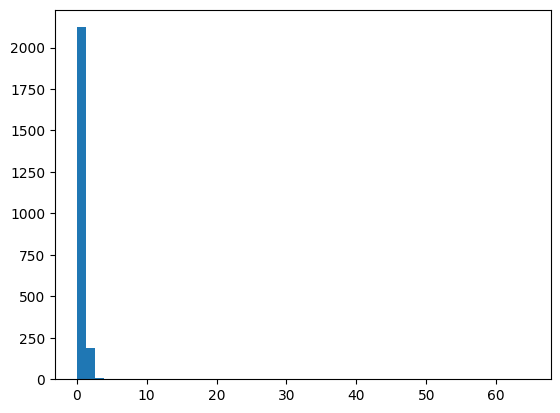

In [15]:
import matplotlib.pyplot as plt
plt.hist(list(Y.values()), bins=50)

In [16]:
if not os.path.exists('./filtered_dt_428'):
    os.makedirs('./filtered_dt_428')
for k, data in filtered_dt.items():
    data.to_csv(f'./filtered_dt_428/{k}_data.csv')

In [17]:
np.unique([len(df.columns) for df in dt.values()])

array([57])

In [18]:
# export dictionary Y
with open('Y.json', 'w') as f:
    json.dump(Y, f)